### **Understanding the Problem**

#### In this notebook, we develop a solution for automating accounting entries using a neural network model based on the T5 architecture.  

##### The code has been designed as a complete application, where each step described in this notebook has been encapsulated into modular and independent functions. This means that processes such as data reading and preprocessing, dataset creation, model training, and the generation and validation of accounting entries are implemented as standalone functions. These functions are invoked from the graphical user interface to provide an interactive experience.

### **Process Overview:**
- **Data Reading & Preprocessing:** Read Excel files containing bank movements, the accounting plan, billing registry, and accounting journal.
- **Dataset Creation:** Build training pairs from the accounting journal.
- **Model Training:** Train a T5 model using a custom PyTorch dataset.
- **Evaluation:** Generate accounting entries from bank movements and perform basic validation.
- **Model Saving:** Save the trained model (using pickle) in the `src/models` folder.

### **Step 1: Importing Libraries, and Reading and preprocessing of the Excel files**

In [2]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install scikit-learn
!pip install openpyxl  # Para leer y escribir archivos Excel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving diario_contable.xlsx to diario_contable.xlsx


In [5]:
from google.colab import files
uploaded = files.upload()

Saving Movimientos_bancarios_preprocesado.xlsx to Movimientos_bancarios_preprocesado (1).xlsx


In [12]:
from google.colab import files
uploaded = files.upload()

Saving plan_contable.xlsx to plan_contable.xlsx


In [1]:
import torch
torch.cuda.is_available()


True

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import T5ForConditionalGeneration, T5Tokenizer
import json
import threading
import tkinter as tk
from tkinter import scrolledtext, messagebox
from tkinter import ttk
from tkinter import filedialog
from PIL import Image, ImageTk  # Requiere: pip install pillow
import os
import warnings
from IPython.display import Image, display
import shutil

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# =============================================================================
# 1. Lectura y Preprocesamiento de los archivos Excel
# =============================================================================

def leer_datos():
    """
    Lee los archivos Excel del proyecto:
      - Movimientos bancarios
      - Plan contable
      - Registro de facturación
      - Diario contable
    """
    movimientos = pd.read_excel("Movimientos_bancarios_preprocesado.xlsx")
    plan_contable = pd.read_excel("plan_contable.xlsx")
    diario_contable = pd.read_excel("diario_contable.xlsx")
    return movimientos, plan_contable, diario_contable

def preprocesar_movimientos(movimientos):
    """
    Para cada movimiento bancario se genera una cadena de texto concatenando
    las columnas: Fecha, Movimiento, Importe y Más datos.
    """
    movimientos['input_text'] = (
        movimientos['Fecha'].astype(str) + " " +
        movimientos['Movimiento'].astype(str) + " " +
        movimientos['Importe'].astype(str) + " " +
        movimientos['Más datos'].astype(str)
    )
    return movimientos

### **Step 2: Creation of the Training Dataset from the Accounting Journal**

In [8]:
# =============================================================================
# 2. Creación del Dataset de Entrenamiento a partir del Diario Contable
# =============================================================================

def generar_pares_movimiento_asiento(movimientos: pd.DataFrame, diario_contable: pd.DataFrame, tolerancia=0.01):
    """
    Relaciona automáticamente movimientos bancarios con asientos contables
    según coincidencia de fecha e importe (teniendo en cuenta signo).
    Devuelve una lista de pares (input_text del movimiento, asiento en formato JSON).
    """
    pares = []

    # Agrupar el diario por asiento
    diario_agrupado = diario_contable.groupby("Asiento")

    # Crear resumen por asiento
    resumen_asientos = []
    for asiento_id, grupo in diario_agrupado:
        try:
            fecha = pd.to_datetime(grupo["Fecha"].iloc[0], dayfirst=True)
        except Exception:
            continue  # saltar si la fecha no es válida
        total_debe = grupo["Debe"].sum()
        total_haber = grupo["Haber"].sum()
        resumen_asientos.append({
            "Asiento": asiento_id,
            "Fecha": fecha,
            "TotalDebe": total_debe,
            "TotalHaber": total_haber,
            "Lineas": grupo
        })

    # Recorrer movimientos bancarios
    for _, mov in movimientos.iterrows():
        try:
            mov_fecha = pd.to_datetime(mov["Fecha"], dayfirst=True)
            mov_importe = float(mov["Importe"])
        except Exception:
            continue

        mov_texto = mov["input_text"]
        importe_abs = abs(mov_importe)

        for resumen in resumen_asientos:
            misma_fecha = resumen["Fecha"].date() == mov_fecha.date()

            if mov_importe >= 0:
                match_importe = abs(resumen["TotalDebe"] - importe_abs) < tolerancia
            else:
                match_importe = abs(resumen["TotalHaber"] - importe_abs) < tolerancia

            if misma_fecha and match_importe:
                lineas_json = []
                for _, row in resumen["Lineas"].iterrows():
                    linea = {
                        "Cuenta": row["Cuenta"],
                        "Debe": row["Debe"],
                        "Haber": row["Haber"],
                        "Descripcion": row["Descripcion"]
                    }
                    lineas_json.append(linea)

                asiento_json = json.dumps({
                    "Asiento": resumen["Asiento"],
                    "Lineas": lineas_json
                }, ensure_ascii=False)

                pares.append((mov_texto, asiento_json))
                break  # solo un match por movimiento

    return pares

def exportar_pares_entrenamiento(pares, ruta_salida="/content/drive/MyDrive/pares_entrenamiento.xlsx"):
    """
    Exporta los pares (input_text, asiento_json) a un archivo Excel para trazabilidad.
    """
    df = pd.DataFrame(pares, columns=["InputText", "AsientoJSON"])
    df.to_excel(ruta_salida, index=False)
    print(f"✅ Pares de entrenamiento exportados a: {ruta_salida}")

### **Step 3: Definition of the Dataset for PyTorch**

In [9]:
# =============================================================================
# 3. Definición del Dataset para PyTorch
# =============================================================================

class AsientosDataset(Dataset):
    """
    Dataset personalizado que recibe una lista de pares (input_text, target_text)
    y utiliza el tokenizer de T5 para codificar los textos de entrada y salida.
    """
    def __init__(self, pairs, tokenizer, max_input_length=512, max_output_length=512):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_text, target_text = self.pairs[idx]
        input_encoding = self.tokenizer.encode_plus(
            input_text,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer.encode_plus(
            target_text,
            max_length=self.max_output_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": target_encoding["input_ids"].squeeze()
        }

### **Step 4: Training of the Encoder-Decoder model**

In [10]:
# =============================================================================
# 4. Entrenamiento del Modelo Encoder-Decoder (T5)
# =============================================================================

def entrenar_modelo(
    dataset,
    model,
    tokenizer,
    epochs=10,
    batch_size=4,
    learning_rate=5e-5,
    progress_callback=None,
    use_early_stopping=False,
    early_stopping_patience=5,
    guardar_mejor_modelo=True,
    generar_grafica=True
):
    """
    Entrena un modelo T5 con el dataset de entrenamiento.
    Permite early stopping, guardado del mejor modelo y graficado de loss.
    """
    warnings.filterwarnings("ignore")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    model.train()

    best_loss = float("inf")
    epochs_sin_mejora = 0
    historial_loss = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        historial_loss.append(avg_loss)
        print(f"Average Loss: {avg_loss:.4f}")

        # Callback para barra de progreso (si es GUI)
        if progress_callback:
            progress_callback(epoch + 1, epochs)

        # Guardar el mejor modelo
        if guardar_mejor_modelo and avg_loss < best_loss:
            best_loss = avg_loss
            model.save_pretrained("../models/trained_t5_model_best")
            tokenizer.save_pretrained("../models/trained_t5_model_best")
            print(f"✅ Nuevo mejor modelo guardado (loss={best_loss:.4f})")

            if use_early_stopping:
                epochs_sin_mejora = 0
        elif use_early_stopping:
            epochs_sin_mejora += 1
            if epochs_sin_mejora >= early_stopping_patience:
                print(f"⛔ Early stopping activado tras {early_stopping_patience} épocas sin mejora.")
                break

    if generar_grafica:
        plt.figure(figsize=(8, 4))
        plt.plot(historial_loss, marker='o')
        plt.title("Evolución del Loss durante el Entrenamiento")
        plt.xlabel("Época")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("../result/loss_curve.png")
        print("📉 Gráfica del loss guardada en ../result/loss_curve.png")

    # Mostrar si existe
    if os.path.exists(ruta_grafica):
        print("📈 Evolución de la pérdida por época:")
        display(Image(filename=ruta_grafica))
    else:
        print("⚠️ La gráfica de pérdida no fue encontrada. Asegúrate de que el entrenamiento haya terminado correctamente.")

    return model

### **Step 9: We train the model**

✅ Pares de entrenamiento exportados a: /content/drive/MyDrive/pares_entrenamiento.xlsx
✅ Ejemplo de par de entrenamiento:
Input: 10/03/2025 CORECOLEGIODEREGISTRADORES -31.54 CORECOLEGIODEREGISTRADORESNOTASINFORMATIVAS,DEPOSITOSYCERTIFICACIONESDESOCIEDADESSOLICITADASAREGISTROSMERCANTILESFEBRERO2025FLEI12051877CABIEDESPARTNERSSCR.
Output: {"Asiento": 10859, "Lineas": [{"Cuenta": 4100004798, "Debe": 31.54, "Haber": NaN, "Descripcion": "PAGO S/F 03/02/2025 NUM 2025/1361"}, {"Cuenta": 5720000001, "Debe": NaN, "Haber": 31.54, "Descripcion": "PAGO COLEGIO DE REGISTRADORES DE ESPAÑA"}]}


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch 1/10


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Average Loss: 0.4639
✅ Nuevo mejor modelo guardado (loss=0.4639)
Epoch 2/10
Average Loss: 0.1901
✅ Nuevo mejor modelo guardado (loss=0.1901)
Epoch 3/10
Average Loss: 0.1513
✅ Nuevo mejor modelo guardado (loss=0.1513)
Epoch 4/10
Average Loss: 0.1304
✅ Nuevo mejor modelo guardado (loss=0.1304)
Epoch 5/10
Average Loss: 0.1162
✅ Nuevo mejor modelo guardado (loss=0.1162)
Epoch 6/10
Average Loss: 0.1062
✅ Nuevo mejor modelo guardado (loss=0.1062)
Epoch 7/10
Average Loss: 0.0987
✅ Nuevo mejor modelo guardado (loss=0.0987)
Epoch 8/10
Average Loss: 0.0922
✅ Nuevo mejor modelo guardado (loss=0.0922)
Epoch 9/10
Average Loss: 0.0872
✅ Nuevo mejor modelo guardado (loss=0.0872)
Epoch 10/10
Average Loss: 0.0830
✅ Nuevo mejor modelo guardado (loss=0.0830)


FileNotFoundError: [Errno 2] No such file or directory: '../result/loss_curve.png'

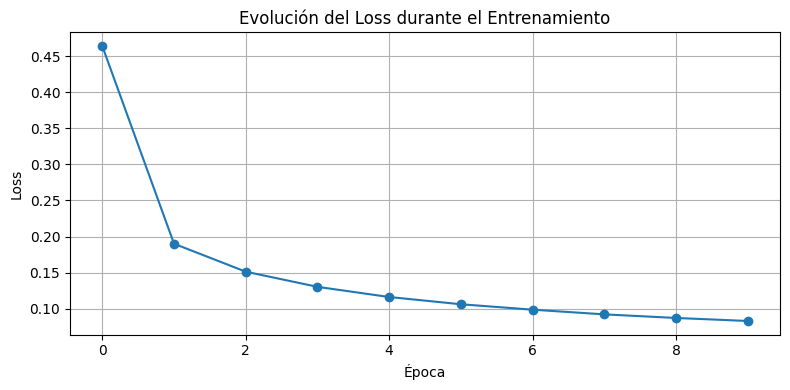

In [16]:
# Paso 1: Cargar y preprocesar los datos
movimientos, plan_contable, diario_contable = leer_datos()
movimientos = preprocesar_movimientos(movimientos)

# Paso 2: Generar pares de entrenamiento
dataset_pairs = generar_pares_movimiento_asiento(movimientos, diario_contable)
exportar_pares_entrenamiento(dataset_pairs)

# Mostrar un ejemplo
print("✅ Ejemplo de par de entrenamiento:")
print("Input:", dataset_pairs[0][0])
print("Output:", dataset_pairs[0][1])

# Paso 3: Tokenizer y modelo
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Paso 4: Crear dataset
asientos_dataset = AsientosDataset(dataset_pairs, tokenizer)

# Paso 5: Entrenar modelo (sin interfaz, con gráfico y early stopping opcional)
trained_model = entrenar_modelo(
    asientos_dataset,
    model,
    tokenizer,
    epochs=10,
    batch_size=2,
    use_early_stopping=True,
    guardar_mejor_modelo=True,
    generar_grafica=True
)

# Paso 6: Guardar el modelo entrenado
model_dir = "/content/drive/MyDrive/trained_t5_model_best"
os.makedirs(model_dir, exist_ok=True)
model.save_pretrained("/content/drive/MyDrive/modelo_entrenado")
tokenizer.save_pretrained("/content/drive/MyDrive/modelo_entrenado")

print(f"✅ Modelo y tokenizer guardados en: {model_dir}")